# Record Linkage Example

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed  # force n2 import to avoid libgomp issue https://github.com/kakao/n2/issues/42

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Load Dataset

We'll use the [Amazon-GoogleProducts](https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution). The dataset is stored in a ZIP file with 3 CSV files: Two are the entity source files, the third one is the perfect mapping.

Let's download the ZIP:

In [6]:
import urllib
import tempfile

dataset_url = 'https://dbs.uni-leipzig.de/file/Amazon-GoogleProducts.zip'
tf = tempfile.NamedTemporaryFile(mode='r', delete=False)
tf.close()

urllib.request.urlretrieve(dataset_url, tf.name);

Extracting the files:

In [7]:
import zipfile
import os

td = tempfile.TemporaryDirectory()

with zipfile.ZipFile(tf.name, "r") as zf:
    zf.extractall(td.name)

os.listdir(td.name)

['Amazon.csv', 'GoogleProducts.csv', 'Amzon_GoogleProducts_perfectMapping.csv']

Now we must read the **two** CSV files `'Amazon.csv'` and `'GoogleProducts.csv'` into a **single** `dict` called `row_dict`. Therefore, `row_dict` will contain all rows from the dataset, i.e., all rows from both files.

We'll dynamically attribute an ID for each row using `enumerate`. entity-embed needs that too.

Also, to keep track of what's source file of a row, we must keep a `__source`.

In [8]:
import csv

from entity_embed.data_utils.utils import Enumerator

id_enumerator = Enumerator()
row_dict = {}
source_attr = '__source'
left_source = 'amazon'
right_source = 'google'

with open(f'{td.name}/Amazon.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row['name'] = row.pop('title')  # in Amazon, name is called title
        row[source_attr] = left_source
        row_dict[row['id']] = row

with open(f'{td.name}/GoogleProducts.csv', newline='', encoding="latin1") as f:
    for row in csv.DictReader(f):
        row['id'] = id_enumerator[row["id"]]
        row[source_attr] = right_source
        row_dict[row['id']] = row

Now we compute the `pos_pair_set`:

In [9]:
pos_pair_set = set()

with open(f'{td.name}/Amzon_GoogleProducts_perfectMapping.csv', newline='') as f:
    for row in csv.DictReader(f):
        id_left = id_enumerator[row['idAmazon']]
        id_right = id_enumerator[row['idGoogleBase']]
        pos_pair_set.add((id_left, id_right))

len(pos_pair_set)

1300

Note internally entity-embed will use **clusters, not pairs**.

For this dataset, the number of clusters is smaller than the number of pairs, because some clusters have more than 2 entities. For example, a cluster with 3 entities means 2 entities from a file link to 1 row from the other file. This is not a problem for entity-embed. In fact, it's important for entity-embed to know the full clusters in order to learn better embeddings. See an example here:

In [10]:
from entity_embed.data_utils import utils

cluster_mapping, cluster_dict = utils.id_pairs_to_cluster_mapping_and_dict(pos_pair_set, row_dict)
len(cluster_dict)

3290

In [11]:
cluster_dict[4]

[262, 2485, 2488]

To use clusters, we must assign them to each row on a `cluster_attr` key:

In [12]:
cluster_attr = 'cluster'
utils.assign_clusters(row_dict, cluster_attr, cluster_mapping)

for id_ in cluster_dict[4]:
    display(row_dict[id_])

{'id': 262,
 'description': 'sp linux we 50 lic/cd 3.0c',
 'manufacturer': 'hewlett packard (consumables)',
 'price': '0',
 'name': 'hp sp linux we 50 lic/cd 3.0c ( t3586a )',
 '__source': 'amazon',
 'cluster': 4}

{'id': 2485,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google',
 'cluster': 4}

{'id': 2488,
 'name': 'sp linux we 50 lic/cd 3.0c',
 'description': '',
 'manufacturer': '',
 'price': '69216.95',
 '__source': 'google',
 'cluster': 4}

Note that there are additional pairs in clusters when compared to `pos_pair_set`. That's because it's useful for entity-embed to also learn that cases like `(2485, 2488)` represent the same entity, even though they belong to the same dataset and won't be returned in the final pairwise results:

In [13]:
from entity_embed.data_utils.utils import cluster_dict_to_id_pairs

len(cluster_dict_to_id_pairs(cluster_dict) - pos_pair_set)

253

From all clusters, we'll use only 20% for training, and other 20% for validation. We want to simulate a real dataset behavior. It's difficult to have a lot of training data:

In [14]:
from entity_embed.data_utils import utils

train_row_dict, valid_row_dict, test_row_dict = utils.split_row_dict_on_clusters(
    row_dict=row_dict,
    cluster_attr=cluster_attr,
    train_proportion=0.2,
    valid_proportion=0.2,
    random_seed=random_seed)

20:03:36 INFO:Singleton cluster sizes (train, valid, test):(437, 437, 1311)
20:03:36 INFO:Plural cluster sizes (train, valid, test):(221, 221, 663)


Note we're splitting the data on **clusters**, not rows, so the row counts vary:

In [15]:
len(train_row_dict), len(valid_row_dict), len(test_row_dict)

(926, 928, 2735)

Clean up the temporary files:

In [16]:
import os

td.cleanup()
os.remove(tf.name)

## Preprocess

We'll perform a very minimal preprocessing of the dataset. We want to simply force ASCII chars, lowercase all chars, strip leading and trailing whitespace, and limit any value to 100 tokens and 1000 chars to avoid memory errors.

The fields we'll clean are the ones we'll use:

In [17]:
attr_list = ['name', 'description', 'manufacturer', 'price']

In [18]:
import unidecode
import itertools
from entity_embed import default_tokenizer

def clean_str(s):
    max_tokens = 100
    max_chars = 1000
    s = unidecode.unidecode(s).lower().strip()
    s_tokens = default_tokenizer(s)[:max_tokens]
    return ' '.join(s_tokens)[:max_chars]

for row in row_dict.values():
    for attr in attr_list:
        row[attr] = clean_str(row[attr])

Forcing ASCII chars in this dataset is useful to improve recall because there's little difference between accented and not-accented chars here. Also, this dataset contains mostly latin chars.

It's worth noting you can use any alphabet you need, so this accent removal is optional.

## Configure entity-embed attributes

Now we will define how row fields (entity attributes) will be numericalized and encoded by the neural network. First we set an `alphabet`, here we'll use ASCII numbers, letters, symbols and space:

In [19]:
from entity_embed.data_utils.attr_config_parser import DEFAULT_ALPHABET

alphabet = DEFAULT_ALPHABET
''.join(alphabet)

'0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

Then we set an `attr_config_dict`. It defines types, which determine how attributes are processed in the neural network:

In [20]:
attr_config_dict = {
    'name': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'semantic_name': {
        'source_attr': 'name',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
    },
    'description': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'semantic_description': {
        'source_attr': 'description',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
    },
    'manufacturer': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'price': {
        'field_type': "STRING",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    }
}

In [21]:
import json

with open('../example-data/rl-example-attr-info.json', 'w') as f:
    json.dump(attr_config_dict, f, indent=4)

Then we use our `attr_config_dict` to get a `row_numericalizer`.

The same `row_numericalizer` must be used on ALL data: train, valid, test. This ensures numericalization will be consistent. Also, one must keep this `row_numericalizer` to use on production data:

In [22]:
from entity_embed import AttrConfigDictParser

row_numericalizer = AttrConfigDictParser.from_dict(attr_config_dict, row_list=row_dict.values())

20:03:36 INFO:For attr=name, computing actual max_str_len
20:03:36 INFO:For attr=name, using actual_max_str_len=26
20:03:36 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
20:03:39 INFO:For attr=description, computing actual max_str_len
20:03:39 INFO:actual_max_str_len=29 must be even to enable NN pooling. Updating to 30
20:03:39 INFO:For attr=description, using actual_max_str_len=30
20:03:40 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
20:03:43 INFO:For attr=manufacturer, computing actual max_str_len
20:03:43 INFO:actual_max_str_len=15 must be even to enable NN pooling. Updating to 16
20:03:43 INFO:For attr=manufacturer, using actual_max_str_len=16
20:03:43 INFO:For attr=price, computing actual max_str_len
20:03:43 INFO:For attr=price, using actual_max_str_len=14


## Initialize Data Module

Under the hoods entity-embed uses [pytorch-lightning](https://www.pytorchlightning.ai/), so we need to create a datamodule object:

In [23]:
clusters_total = len(cluster_dict)
clusters_total

3290

Since there's a lot of clusters, we'll use only 200 for training, and other 200 for validation. We want to simulate a real dataset behavior. It's difficult to have a lot of training data for record linkage.

In [24]:
from entity_embed import LinkageDataModule

batch_size = 32
eval_batch_size = 64
datamodule = LinkageDataModule(
    train_row_dict=train_row_dict,
    valid_row_dict=valid_row_dict,
    test_row_dict=test_row_dict,
    source_attr=source_attr,
    left_source=left_source,
    cluster_attr=cluster_attr,
    row_numericalizer=row_numericalizer,
    batch_size=batch_size,
    eval_batch_size=eval_batch_size,
    random_seed=random_seed
)

We've used `LinkageDataModule` because we're doing Record Linkage of a multiple datasets/tables.

We're NOT doing Deduplication of a single dataset here. Check the other notebook Deduplication if you want to learn how to do it with entity-embed.

## Training

Now the training process! Thanks to pytorch-lightining, it's easy to train, validate, and test with the same datamodule.

We must choose the approximate nearest neighbors K, i.e., the top N our model will use to find duplicates in the embedding space. Below we're setting it on `ann_k` and initializing the `EntityEmbed` model object:

In [25]:
from entity_embed import LinkageEmbed

ann_k = 100
model = LinkageEmbed(
    row_numericalizer,
    ann_k=ann_k,
    source_attr=source_attr,
    left_source=left_source,
)

To train, we use a [pytorch-lightning Trainer](https://pytorch-lightning.readthedocs.io/en/1.1.6/trainer.html).

Since entity-embed is focused in recall, we'll use `valid_recall_at_0.3` for early stopping. But we'll set `min_epochs = 5` to avoid a very low precision.

`0.3` here is the threshold for cosine similarity of embedding vectors. Note we're using a validation metric, as the training process will run validation on every epoch due to `check_val_every_n_epoch=1`.

We also set a `TensorBoardLogger`, thus you can use `tensorboard --logdir notebooks/tb_logs` to check the train and valid metrics.

In [26]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from entity_embed.early_stopping import EarlyStoppingMinEpochs, ModelCheckpointMinEpochs

min_epochs = 5
max_epochs = 100
monitor = 'valid_recall_at_0.3'
early_stop_callback = EarlyStoppingMinEpochs(
    min_epochs=min_epochs,
    monitor=monitor,
    min_delta=0.00,
    patience=10,
    verbose=True,
    mode='max'
)
checkpoint_callback = ModelCheckpointMinEpochs(
    min_epochs=min_epochs,
    monitor=monitor,
    save_top_k=1,
    mode='max',
    verbose=False,
)
tb_save_dir = 'tb_logs'
tb_name = 'amazon-google'
trainer = pl.Trainer(
    gpus=1,
    min_epochs=min_epochs,
    max_epochs=max_epochs,
    check_val_every_n_epoch=1,
    callbacks=[early_stop_callback],
    logger=TensorBoardLogger(tb_save_dir, name=tb_name),
    reload_dataloaders_every_epoch=True
)

GPU available: True, used: True
20:03:43 INFO:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
20:03:43 INFO:TPU available: None, using: 0 TPU cores


OK, all set, call `fit`!

In [27]:
trainer.fit(model, datamodule)

20:03:43 INFO:Train positive pair count: 268
20:03:43 INFO:Valid positive pair count: 270
20:03:43 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 14.7 M
1 | loss_fn     | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
5.6 M     Non-trainable params
14.7 M    Total params
58.980    Total estimated model params size (MB)
20:04:38 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 14.7 M
1 | loss_fn     | SupConLoss | 0     
-------------------------------------------
9.2 M     Trainable params
5.6 M     Non-trainable params
14.7 M    Total params
58.980    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

Now training is done, we can easily check which attributes are most important for the final embedding:

In [52]:
model.blocker_net.get_signature_weights()

{'name': 0.22535941004753113,
 'semantic_name': 0.21788804233074188,
 'description': 0.1766599863767624,
 'semantic_description': 0.16664648056030273,
 'manufacturer': 0.10755649209022522,
 'price': 0.10588961094617844}

And we can check the best validation model:

In [29]:
trainer.checkpoint_callback.best_model_path

'tb_logs/amazon-google/version_5/checkpoints/epoch=21-step=659.ckpt'

In [30]:
from entity_embed import validate_best

validate_best(trainer)

20:08:52 INFO:Validating best model...


{'valid_f1_at_0.3': 0.19711004075583552,
 'valid_f1_at_0.5': 0.5714285714285714,
 'valid_f1_at_0.7': 0.7374301675977653,
 'valid_pair_entity_ratio_at_0.3': 2.617456896551724,
 'valid_pair_entity_ratio_at_0.5': 0.6519396551724138,
 'valid_pair_entity_ratio_at_0.7': 0.28771551724137934,
 'valid_precision_at_0.3': 0.10951008645533142,
 'valid_precision_at_0.5': 0.4132231404958678,
 'valid_precision_at_0.7': 0.7415730337078652,
 'valid_recall_at_0.3': 0.9851851851851852,
 'valid_recall_at_0.5': 0.9259259259259259,
 'valid_recall_at_0.7': 0.7333333333333333}

## Testing

With the best validation model (`ckpt_path='best'`), we can check the performance on the test set: 

In [31]:
trainer.test(ckpt_path='best', verbose=False)

20:09:01 INFO:Test positive pair count: 762
20:09:01 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_f1_at_0.3': 0.07390773736880644,
  'test_f1_at_0.5': 0.3326469915351178,
  'test_f1_at_0.7': 0.5509921550530688,
  'test_pair_entity_ratio_at_0.3': 7.211334552102376,
  'test_pair_entity_ratio_at_0.5': 1.3195612431444241,
  'test_pair_entity_ratio_at_0.7': 0.5137111517367459,
  'test_precision_at_0.3': 0.038381584951579374,
  'test_precision_at_0.5': 0.20144084233859794,
  'test_precision_at_0.7': 0.42491103202846975,
  'test_recall_at_0.3': 0.9934383202099738,
  'test_recall_at_0.5': 0.9540682414698163,
  'test_recall_at_0.7': 0.7834645669291339}]

## Testing manually (like a production run)

When running in production, you only have access to the trained `model` object and the production `row_dict` (without the `cluster_attr` filled, of course).

So let's simulate that by removing `cluster_attr` from the test_row_dict:

In [32]:
import copy

test_row_dict_with_cluster = datamodule.test_row_dict
test_row_dict = copy.deepcopy(test_row_dict_with_cluster)

for row in test_row_dict.values():
    del row[cluster_attr]

Keep the `test_pos_pair_set` in a variable for evaluation:

In [33]:
test_pos_pair_set = datamodule.test_pos_pair_set

Then call `predict`:

In [34]:
test_left_vector_dict, test_right_vector_dict = model.predict(
    row_dict=test_row_dict,
    batch_size=eval_batch_size
)

# batch embedding:   0%|          | 0/43 [00:00<?, ?it/s]

Double-check if returned embeddings on `test_left_vector_dict` and `test_right_vector_dict` have the same length of `test_row_dict`:

In [35]:
assert (len(test_left_vector_dict) + len(test_right_vector_dict)) == len(test_row_dict)

Now init an `ANNLinkageIndex`, insert all embeddings from both `test_left_vector_dict` and `test_right_vector_dict` on it, and build it:

In [36]:
%%time

from entity_embed import ANNLinkageIndex

ann_index = ANNLinkageIndex(embedding_size=model.embedding_size)
ann_index.insert_vector_dict(left_vector_dict=test_left_vector_dict, right_vector_dict=test_right_vector_dict)
ann_index.build()

CPU times: user 1.09 s, sys: 19.8 ms, total: 1.11 s
Wall time: 165 ms


With the index built, we can now search on it and find the candidate duplicate pairs:

In [39]:
%%time

sim_threshold = 0.3
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold,
    left_vector_dict=test_left_vector_dict,
    right_vector_dict=test_right_vector_dict,
    left_source=left_source
)

CPU times: user 1.49 s, sys: 14.3 ms, total: 1.51 s
Wall time: 310 ms


Let's check now the metrics of the found duplicate pairs:

In [40]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_row_dict))

7.211334552102376

In [41]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_pos_pair_set)

(0.038381584951579374, 0.9934383202099738)

Same numbers of the `trainer.test`, so our manual testing is fine.

Finally, we can check the false positives and negatives to see if they're really difficult:

In [42]:
false_positives = list(found_pair_set - test_pos_pair_set)
len(false_positives)

18966

In [43]:
false_negatives = list(test_pos_pair_set - found_pair_set)
len(false_negatives)

5

In [44]:
cos_similarity = lambda a, b: np.dot(a, b)

In [45]:
for (id_left, id_right) in false_positives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            utils.subdict(row_dict[id_left], attr_list), utils.subdict(row_dict[id_right], attr_list)
        )
    )

(0.66789985,
 {'name': 'cisco ios enterprise services - complete package ( cd28 - esk9 = )',
  'description': "cisco ios software is the world ' s leading network infrastructure software delivering a seamless integration of technology innovation business - critical services and hardware support . currently operating on over ten million active systems ranging from the small home office router to the core systems of the world ' s largest service provider networks cisco ios software is the most widely leveraged network infrastructure software in the world .",
  'manufacturer': 'cisco systems - enterprise',
  'price': '0'},
 {'name': 'cd384 - aisk9 = cisco ios advanced ip services - complete package - cd',
  'description': 'cisco systems cd384 - aisk9 = : usually ships in 24 hours : in stock : cisco ios ( internetworking operating system ) software is the platform that delivers network services and enables networked applications .',
  'manufacturer': '',
  'price': '2068 . 26'})

(0.36533555,
 {'name': 'adobe creative suite cs3 web standard [ mac ]',
  'description': 'adobe creative suite 3 web standard software is the basic toolkit for web designers and developers . it offers all - new versions of fundamental tools for creating and maintaining interactive websites applications and mobile device content . prototype your projects design assets and build and maintain professional web experiences . flash cs3 professional for interactive design dreamweaver cs3 for web design and development acrobat 8 professional for adobe pdf workflows build your prototype with adobe fireworks cs3 streamline web design development and maintenance adobe creative suite 3 web standard software is the basic toolkit for web designers and developers',
  'manufacturer': 'adobe',
  'price': '999'},
 {'name': 'adobe fireworks cs3 academic',
  'description': 'system requirements powerpc g4 or g5 or intel core processor mac os x v10 . 4 . 8 512mb ram ( 1gb recommended ) 1gb free hard - disk 

(0.329875,
 {'name': 'reader rabbit playtime for baby and toddler',
  'description': 'explore colors shapes songs animals letters numbers and more with your baby or toddler . discover the happy and colorful world of reader rabbit -- an enchanted land of fun and learning -- with your child .',
  'manufacturer': 'the learning company',
  'price': '19 . 99'},
 {'name': 'aspyr prey',
  'description': 'minimum system requirements : operating system : mac os x 10 . 3 . 9 or later cpu processor : powerpc g5 or intel chipset cpu speed : 1 . 8 ghz memory : 512 mb or higher hard disk space : 2 . 5gb free disk space video card ( ati ): radeon 9600 video card ( nvidia ): ...',
  'manufacturer': '',
  'price': '47 . 99'})

In [46]:
for (id_left, id_right) in false_negatives[:3]:
    display(
        (
            cos_similarity(test_left_vector_dict[id_left], test_right_vector_dict[id_right]),
            utils.subdict(row_dict[id_left], attr_list), utils.subdict(row_dict[id_right], attr_list)
        )
    )

(0.24779467,
 {'name': 'ca arcserve bkup r11 . 5 win dro sp1 prod only',
  'description': "server disasters can and do happen : fire flood theft fraud virus or human error to name a few . the disaster recovery option simplifies and streamlines rebuilding of the server by automating the restoration of your operating system and preferences . you ' ll then be able to quickly recover your data and drastically cut down the time to recover from a server disaster . a backup / recovery solution isn ' t usable until you get your server quickly restored to its original state and ready for recovery of the data you have backed up . it ensures",
  'manufacturer': 'computer associates',
  'price': '0'},
 {'name': 'computer associates babwbr1151s05 bab r11 . 5 sp1 dro win m / l cd',
  'description': 'bab r11 . 5 sp1 dro win m / l cd',
  'manufacturer': '',
  'price': '431 . 16'})

(-0.013282035,
 {'name': 'iplaymusic beginner guitar lessons for the mac and ipod',
  'description': "iplaymusic ' s beginner guitar lessons is the first guitar learning program optimized for the mac and video ipod . the software takes advantage of ilife applications resident on today ' s mac including garageband itunes and iweb . now aspiring musicians have everything they need to learn guitar play and sing popular songs and easily create their own performances . users can view lessons or listen to their new performances in itunes or on their ipod",
  'manufacturer': 'iplaymusic',
  'price': '49 . 99'},
 {'name': "wingnuts 2 : raina ' s revenge",
  'description': 'system requirements : mac os x 10 . 4 + g4 / g5 / intel 800 + mhz cpu 512 mb ram 32 mb video card 950 mb hard drive space',
  'manufacturer': '',
  'price': '28 . 99'})

(0.28036007,
 {'name': 'tiny term emulator v4 . 3x',
  'description': '- marketing information : tinyterm provides accurate emulation and total flexibility . now you can use your desktop pc to access all your legacy data and applications . with tinyterm you can customize access depending on your companyandquot ; s needs . you can provide just one user with access to your host or provide host access to your entire company . with its support for multinational keyboards and host character sets you can make tinyterm your solution for global host access . product information - software sub type : emulation - software name : tinyterm v . 4 .',
  'manufacturer': 'century software',
  'price': '219 . 63'},
 {'name': 'century software tt - 1 - century tinyterm v . 4 . 3x - emulation - 1 user ( s ) - english french german spanish italian polish portuguese - pc',
  'description': "century software tt - 1 : tinyterm provides accurate emulation and total flexibility . now you can use your desktop p

## t-sne visualization

Let's visualize a small sample of the test embeddings and see if they look properly clustered:

In [47]:
vis_sample_size = 10

In [48]:
test_vector_dict = {**test_left_vector_dict, **test_right_vector_dict}
test_cluster_dict = utils.row_dict_to_cluster_dict(test_row_dict_with_cluster, cluster_attr)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [49]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [50]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=25, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

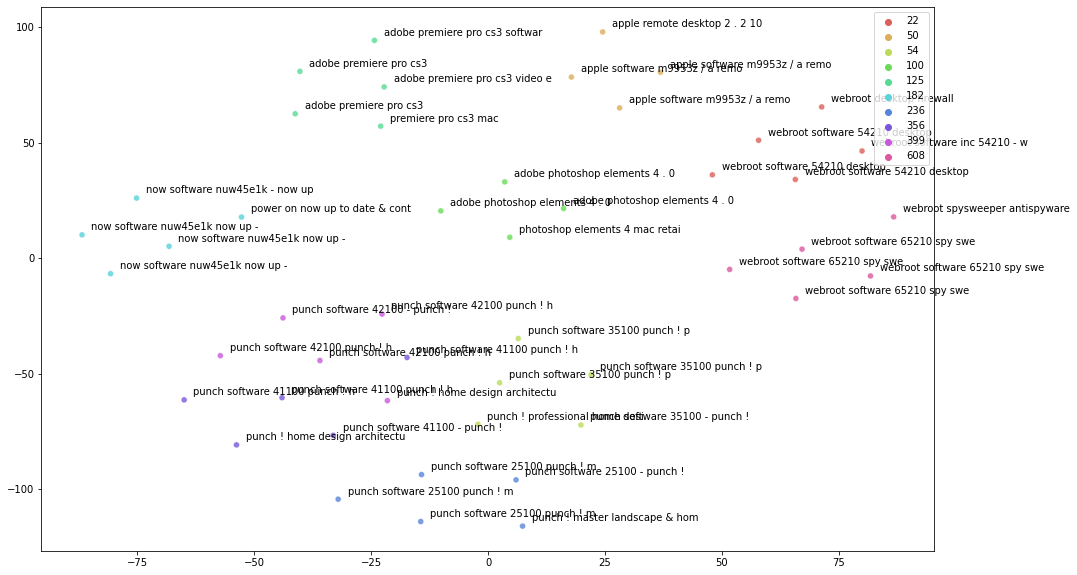

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_row_dict[id_]['name'][:30]
    ax.text(x + 2, y + 2, text)